## Installation bibliotheque et importation librairies

In [1]:
!pip install pandas
!pip install xlrd

In [2]:
import warnings
import os
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt  # Matlab style plot
plt.style.use('fivethirtyeight')
import seaborn as sns # affichage, on peut utiliser d'autres librairies
import statsmodels.api as sm # modèle stat contenant le modèle ARIMA

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from scipy import stats
from scipy.stats import normaltest

color = sns.color_palette()
sns.set_style('darkgrid')

## Preparation des donnees pour analyse

In [3]:
# Spécifiez le chemin du fichier Excel .xls
chemin_fichier_xls1 = 'C:/Users/nadia/Downloads/prediction conso/data1.xlsx'
chemin_fichier_xls2 = 'C:/Users/nadia/Downloads/prediction conso/data2.xlsx'

# Utilisez la fonction read_excel en spécifiant le moteur 'xlrd'
df1 = pd.read_excel(chemin_fichier_xls1)
df2 = pd.read_excel(chemin_fichier_xls2)
df = pd.concat([df1, df2])
#df.head()

In [4]:
df = df.drop(df.index[-1])
df = df.drop(df.index[49536])

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['Heures'] = pd.to_datetime(df['Heures'], format='%H:%M:%S').dt.time
df['datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Heures'].astype(str))
data= df[['datetime', 'Consommation']]

In [6]:
data= data.dropna()
#data.head()

In [7]:
num_rows = data.shape[0]

print("Number of Rows:", num_rows)

Number of Rows: 78313


In [8]:
# Round the datetime column to the nearest hour
data['rounded_datetime'] = data['datetime'].dt.floor('H')

# Drop duplicates based on the rounded datetime, keeping only the first occurrence
data = data.drop_duplicates(subset='rounded_datetime')

# Drop the additional columns created for processing, if necessary
data = data.drop(['rounded_datetime'], axis=1)

## Prediction consommation avec Random Forest

In [9]:
## pour RF
df = data
df.set_index('datetime', inplace=True)
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df['day_of_week'] = df.index.day_of_week

In [11]:
df.head()

,Consommation,hour,day,month,year,day_of_week
datetime,,,,,,
2021-01-01 00:00:00,67010.0,0,1,1,2021,4
2021-01-01 01:00:00,65052.0,1,1,1,2021,4
2021-01-01 02:00:00,64376.0,2,1,1,2021,4
2021-01-01 03:00:00,61883.0,3,1,1,2021,4
2021-01-01 04:00:00,59103.0,4,1,1,2021,4


In [12]:
df.shape[0]

25771

Mean Squared Error: 10224116.48461969
Mean Absolute Error (MAE): 2406.7756450048496
Root Mean Squared Error (RMSE): 3197.5172375797583


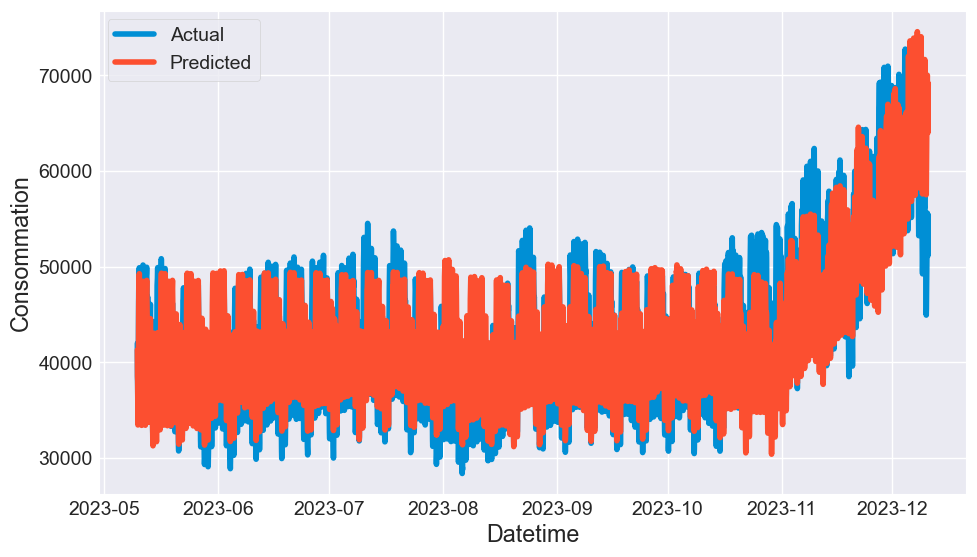

In [13]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:]

# Select features and target variable
features = ['hour', 'day', 'month', 'day_of_week', 'year']
target = 'Consommation'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Train a RandomForestRegressor (you can experiment with other models)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.xlabel('Datetime')
plt.ylabel('Consommation')
plt.legend()
plt.show()

## Prediction avec LSTM 

In [9]:
!pip install tensorflow
!pip install scikit-learn

In [10]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming df is your DataFrame with a 'datetime' column and a 'consumption' column
# Make sure 'datetime' is of pandas datetime type
df= data
df.set_index('datetime', inplace=True)

# Extract the consumption values
consumption_values = df['Consommation'].values.reshape(-1, 1)

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
consumption_values_scaled = scaler.fit_transform(consumption_values)

# Function to create LSTM dataset with time steps
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        a = data[i:(i + time_steps), 0]
        X.append(a)
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Set the number of time steps for the LSTM
time_steps = 24  # You can adjust this based on your data

# Create the LSTM dataset
X, y = create_lstm_dataset(consumption_values_scaled, time_steps)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:]
y_train, y_test = y[0:train_size], y[train_size:]

# Reshape the input data to be 3D [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))





Epoch 1/50

616/616 [==============================] - 12s 14ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 2/50
616/616 [==============================] - 7s 12ms/step - loss: 0.0017 - val_loss: 7.3826e-04
Epoch 3/50
616/616 [==============================] - 8s 12ms/step - loss: 0.0012 - val_loss: 7.8217e-04
Epoch 4/50
616/616 [==============================] - 8s 12ms/step - loss: 9.9547e-04 - val_loss: 6.1449e-04
Epoch 5/50
616/616 [==============================] - 7s 12ms/step - loss: 8.9769e-04 - val_loss: 5.1644e-04
Epoch 6/50
616/616 [==============================] - 8s 13ms/step - loss: 8.0073e-04 - val_loss: 4.7892e-04
Epoch 7/50
616/616 [==============================] - 7s 12ms/step - loss: 7.8039e-04 - val_loss: 4.4682e-04
Epoch 8/50
616/616 [==============================] - 8s 13ms/step - loss: 7.4138e-04 - val_loss: 4.7871e-04
Epoch 9/50
616/616 [==============================] - 7s 12ms/step - loss: 7.5167e-04 - val_loss: 4.4456e-04
Epoch 10/50
616/616 [==========

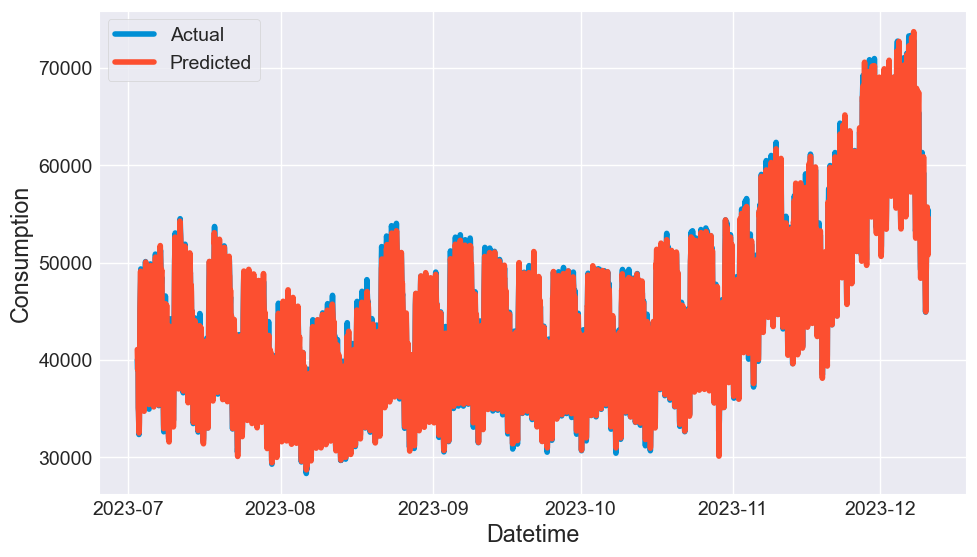

In [11]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the scaled predictions and actual values to the original scale
y_pred_actual = scaler.inverse_transform(np.reshape(y_pred, (len(y_pred), 1)))
y_test_actual = scaler.inverse_transform(np.reshape(y_test, (len(y_test), 1)))

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual, y_pred_actual)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size + time_steps:], y_test_actual, label='Actual')
plt.plot(df.index[train_size + time_steps:], y_pred_actual, label='Predicted')
plt.xlabel('Datetime')
plt.ylabel('Consumption')
plt.legend()
plt.show()


In [12]:
# Calculate NMAE pour LstM
from sklearn.metrics import mean_absolute_error

def calculate_nmae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    target_range = max(y_true) - min(y_true)
    nmae = mae / target_range
    return nmae

nmae = calculate_nmae(y_test_actual, y_pred_actual)

# Display the result
print(f'Normalized Mean Absolute Error (NMAE): {nmae}')

Normalized Mean Absolute Error (NMAE): [0.01269636]


In [12]:
chemin_fichier_xls3 = 'C:/Users/nadia/Downloads/prediction conso/data3.xlsx'
data3= pd.read_excel(chemin_fichier_xls3)
data3['Date'] = pd.to_datetime(data3['Date'])
data3['Heures'] = pd.to_datetime(data3['Heures'], format='%H:%M:%S').dt.time
data3['datetime'] = pd.to_datetime(data3['Date'].astype(str) + ' ' + data3['Heures'].astype(str))
data3= data3[['datetime', 'Consommation']]
data3= data3.dropna()

# Round the datetime column to the nearest hour
data3['rounded_datetime'] = data3['datetime'].dt.floor('H')

# Drop duplicates based on the rounded datetime, keeping only the first occurrence
data3 = data3.drop_duplicates(subset='rounded_datetime')

# Drop the additional columns created for processing, if necessary
data3 = data3.drop(['rounded_datetime'], axis=1)
data3.head()

num_rows = data3.shape[0]

print("Number of Rows:", num_rows)

Number of Rows: 24


In [13]:
df1=data3
df1.set_index('datetime', inplace=True)

# Extract the consumption values
consumption_values = df1['Consommation'].values.reshape(-1, 1)

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
consumption_values_scaled = scaler.fit_transform(consumption_values)

# Function to create LSTM dataset with time steps
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        a = data[i:(i + time_steps), 0]
        X.append(a)
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Set the number of time steps for the LSTM
time_steps = 1  # You can adjust this based on your data

# Create the LSTM dataset
X_t, y_t = create_lstm_dataset(consumption_values_scaled, time_steps)

train_size = int(len(X) * 1)
X_tes= X_t[0:train_size]
y_tes= y_t[0:train_size]

# Reshape the input data to be 3D [samples, time steps, features]
X_tes = np.reshape(X_tes, (X_tes.shape[0], X_tes.shape[1], 1))


In [14]:
# Make predictions on the test set
y_p = model.predict(X_tes)

# Inverse transform the scaled predictions and actual values to the original scale
y_p_a = scaler.inverse_transform(np.reshape(y_p, (len(y_p), 1)))
y_tes_a = scaler.inverse_transform(np.reshape(y_tes, (len(y_tes), 1)))

1/1 [==============================] - 1s 801ms/step


In [15]:
len(y_tes_a)

23

In [16]:
df1.index[time_steps:]

DatetimeIndex(['2023-12-04 01:00:00', '2023-12-04 02:00:00',
               '2023-12-04 03:00:00', '2023-12-04 04:00:00',
               '2023-12-04 05:00:00', '2023-12-04 06:00:00',
               '2023-12-04 07:00:00', '2023-12-04 08:00:00',
               '2023-12-04 09:00:00', '2023-12-04 10:00:00',
               '2023-12-04 11:00:00', '2023-12-04 12:00:00',
               '2023-12-04 13:00:00', '2023-12-04 14:00:00',
               '2023-12-04 15:00:00', '2023-12-04 16:00:00',
               '2023-12-04 17:00:00', '2023-12-04 18:00:00',
               '2023-12-04 19:00:00', '2023-12-04 20:00:00',
               '2023-12-04 21:00:00', '2023-12-04 22:00:00',
               '2023-12-04 23:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)

In [23]:
y_p_a = np.concatenate((y_p_a[1:], [y_p_a[0]]))

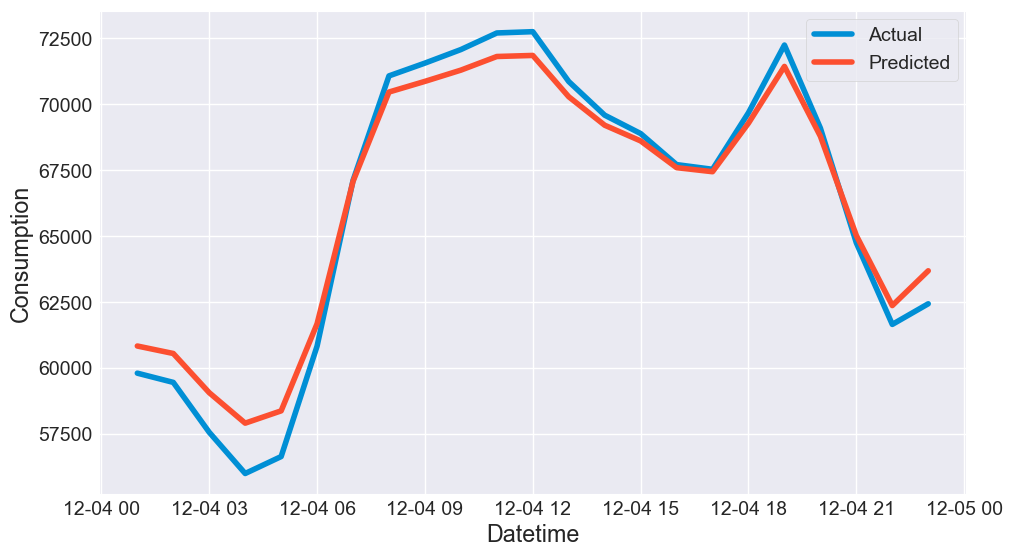

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(df1.index[time_steps:], y_tes_a, label='Actual')
plt.plot(df1.index[time_steps:], y_p_a, label='Predicted')
plt.xlabel('Datetime')
plt.ylabel('Consumption')
plt.legend()
plt.show()

In [25]:
y_p_a

array([[60834.76 ],
       [60551.152],
       [59064.594],
       [57908.984],
       [58375.363],
       [61680.12 ],
       [67080.27 ],
       [70467.47 ],
       [70872.234],
       [71298.33 ],
       [71815.51 ],
       [71855.59 ],
       [70288.06 ],
       [69208.99 ],
       [68613.55 ],
       [67599.54 ],
       [67445.66 ],
       [69288.99 ],
       [71439.4  ],
       [68789.92 ],
       [65023.79 ],
       [62368.945],
       [63688.406]], dtype=float32)

## Essaie de prediction en Sarima (marche pas car donnees complexes et relation non lineaire)

In [14]:
!pip install statsmodels

In [22]:
y=data
y=pd.Series(data['Consommation'].values, index=data['datetime'])

In [34]:
print(y.dtypes)

float64


In [35]:
y.describe()

count    78313.000000
mean     49712.451241
std      10988.908740
min      28344.000000
25%      41709.000000
50%      47794.000000
75%      55944.000000
max      88440.000000
dtype: float64

In [36]:
print(y)

datetime
2021-01-01 00:00:00    67010.0
2021-01-01 00:30:00    67071.0
2021-01-01 01:00:00    65052.0
2021-01-01 01:30:00    64918.0
2021-01-01 02:00:00    64376.0
                        ...   
2023-12-10 17:15:00    53274.0
2023-12-10 17:30:00    54097.0
2023-12-10 17:45:00    54602.0
2023-12-10 18:00:00    55383.0
2023-12-10 18:15:00    56012.0
Length: 78313, dtype: float64


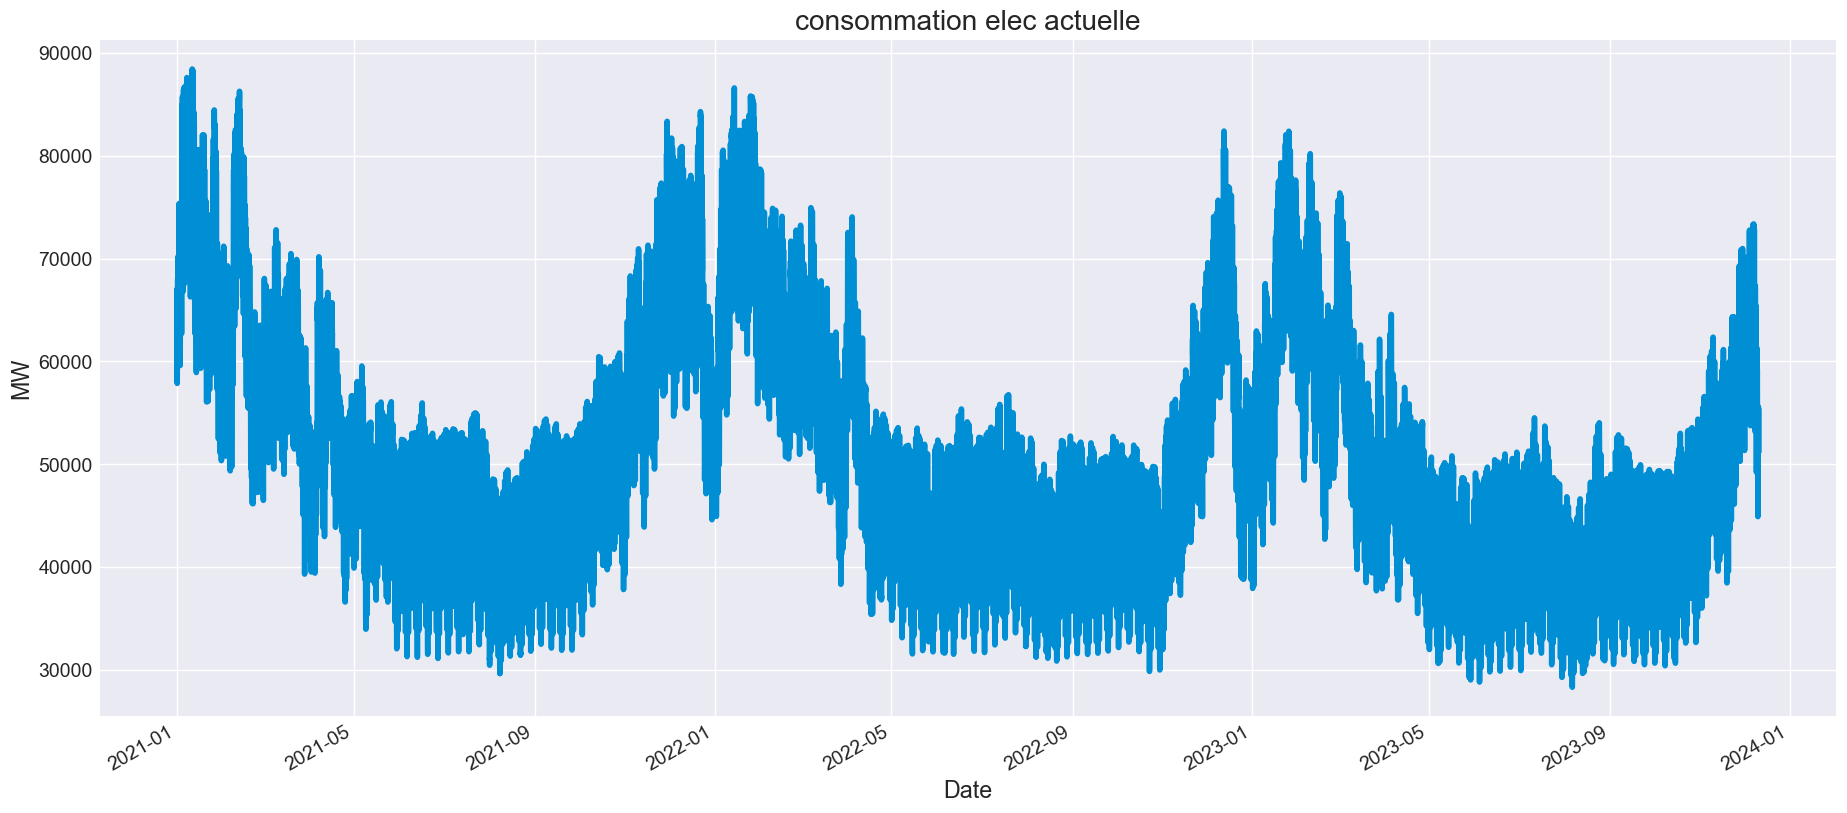

In [16]:
plt.figure(figsize=(20,10))
y.plot()
plt.gca().set(title='consommation elec actuelle', xlabel='Date', ylabel='MW')
plt.show()

il ya une periodicite annuelle

<Axes: xlabel='datetime', ylabel='Consommation'>

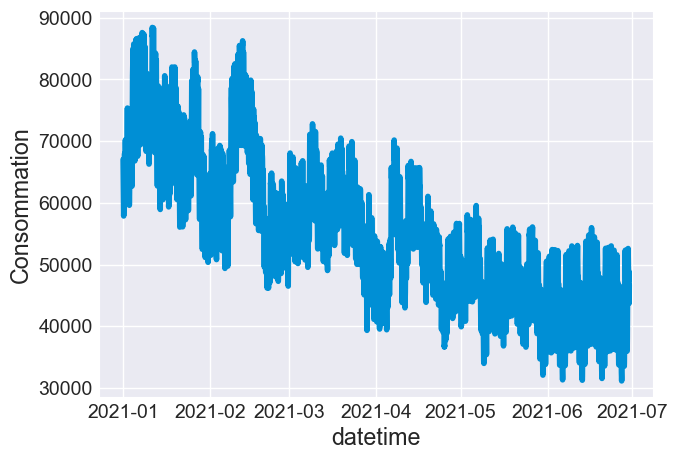

In [17]:
sns.lineplot(x="datetime", y="Consommation",legend = 'full' , data=data[:4320])

il n'y a pas de periodicite mensuelle

<Axes: xlabel='datetime', ylabel='Consommation'>

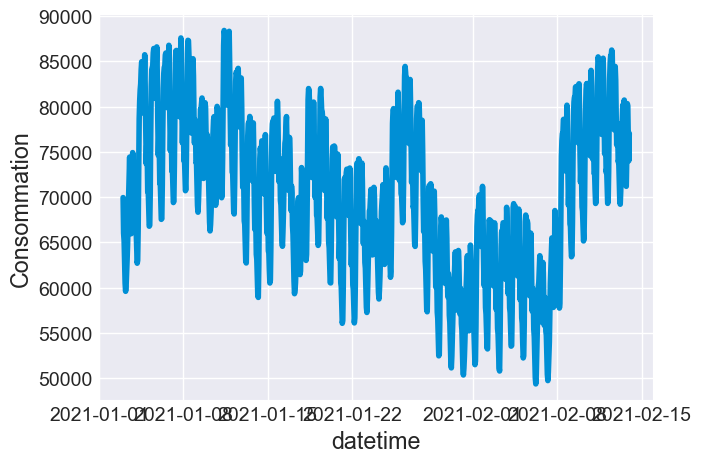

In [18]:
sns.lineplot(x="datetime", y="Consommation",legend = 'full' , data=data[48:1056])

il n'y a pas de periodicite hebdomadaire (pas visible en tout cas)

<Axes: xlabel='datetime', ylabel='Consommation'>

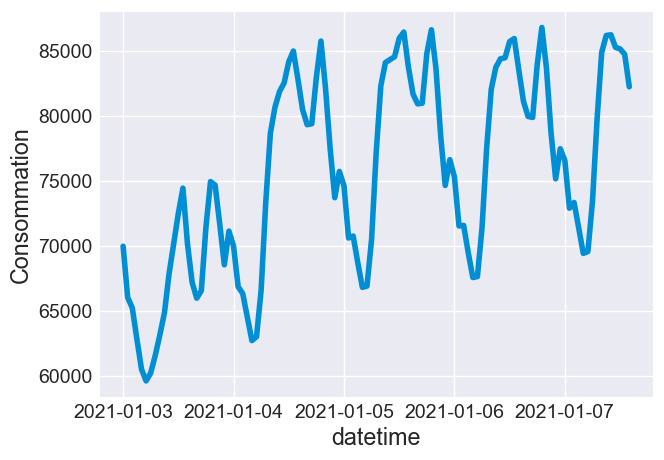

In [19]:
sns.lineplot(x="datetime", y="Consommation",legend = 'full' , data=data[48:159])

periodicite journaliere 

In [25]:
from statsmodels.tsa.stattools import adfuller

# cette fonction a été complétée afin d'observer le signal 
# et d'expliquer le résultat du test (on peut se contenter de la p-value 
# et de la valeur du test)

def test_stationarity2(timeseries, window = 36, cutoff = 0.01):
    
    #Perform Dickey-Fuller test:
    print('Resultats du Test de Dickey-Fuller :')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 36 )
    # maxlag et autolag
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistique','p-value','#Lags utilisés','Nombre d observations utilisées'])
    for key,value in dftest[4].items():
        dfoutput['Valeur critique (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. La série est vraisemblablement stationnaire.' % pvalue)
    else:
        print('p-value = %.4f. La série est vraisemblablement non stationnaire.' % pvalue)
    
    print(dfoutput)

In [26]:
test_stationarity2(y,36)

Resultats du Test de Dickey-Fuller :
p-value = 0.0000. La série est vraisemblablement stationnaire.
Test Statistique                  -5.847877e+00
p-value                            3.647336e-07
#Lags utilisés                     3.600000e+01
Nombre d observations utilisées    2.573400e+04
Valeur critique (1%)              -3.430604e+00
Valeur critique (5%)              -2.861652e+00
Valeur critique (10%)             -2.566830e+00
dtype: float64


serie stationnaire sans differentielle donc on peut initialiser la valeur de d a 0

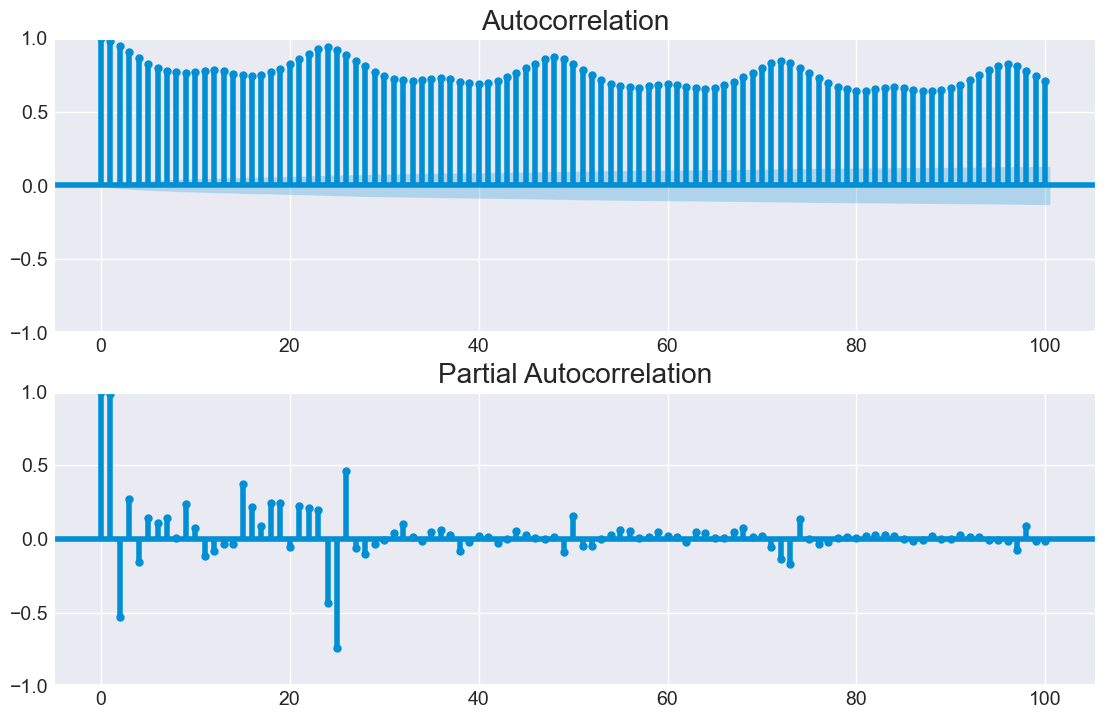

In [28]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=100, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=100, ax=ax2)# , lags=40


on avait d= 0
p= 6 minimum
il ya un terme de saisonnabilite de 48

C:\Users\nadia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 6983561967.353971


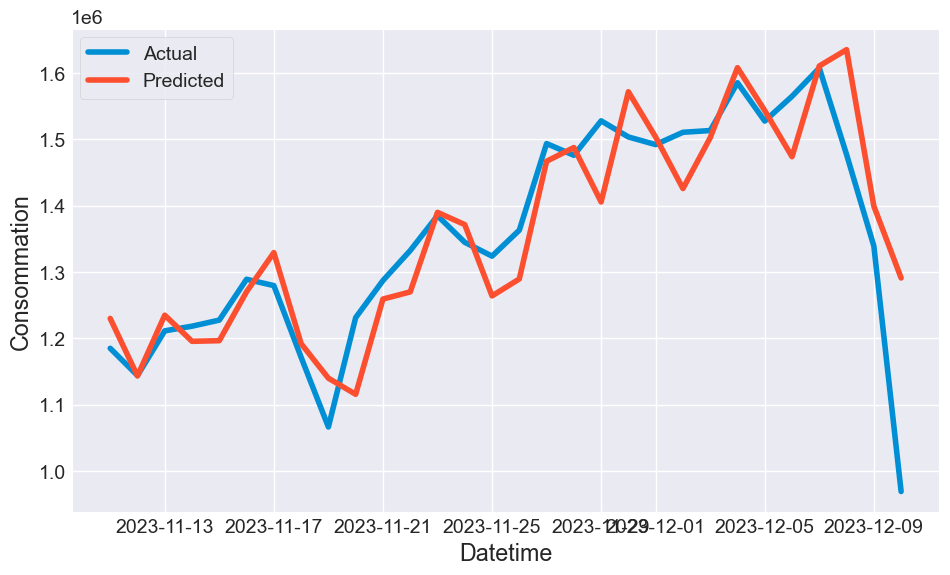

In [23]:

from statsmodels.tsa.arima.model import ARIMA

# Assuming df is your DataFrame with a 'datetime' column and a 'consumption' column
# Make sure 'datetime' is of pandas datetime type

# Resample the data to a daily frequency (you can adjust the frequency based on your data)
df_daily = df.resample('D').sum()

# Fit ARIMA model
order = (7, 1, 3)  # Example order, you may need to adjust based on your data
model = ARIMA(df_daily['Consommation'], order=order)
results = model.fit()

# Make predictions on the test set
start_index = len(df_daily) - 30  # Assuming you want to predict the last 30 days
end_index = len(df_daily) - 1
y_pred = results.predict(start=start_index, end=end_index, typ='levels')

# Evaluate the model using Mean Squared Error (MSE)
y_test = df_daily['Consommation'][start_index:end_index + 1]
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_daily.index[start_index:end_index + 1], y_test, label='Actual')
plt.plot(df_daily.index[start_index:end_index + 1], y_pred, label='Predicted')
plt.xlabel('Datetime')
plt.ylabel('Consommation')
plt.legend()
plt.show()
